# CNN Training

Target of this code is to train a CNN network to classify images of a digital readout to the digits 0 to 9. Additionally a category "NaN" is introduced, to mark images that are not amibiguous.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "dig1020s3"   # Used for tflite Filename
Training_Percentage = 0.0              # 0.0 = Use all Images for Training
Epoch_Anz = 500

##########################################################################


import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import History 
from tensorflow.keras.utils import to_categorical
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

### Load training data
* The data is expected in the "Input_dir"
* Inside subdirectories are expected from -1, 0, 1, ... 9 in which the pictures are sorted according to their values (=category)
* Picture size must be 20x32 with 3 color channels (RGB)
* The filename can be arbitrary

* The images are stored in the x_data[]
* The expected category for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) and split the data into training and validation data

In [2]:
Input_dir='ziffer_sortiert_resize'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '/*.jpg')
    if aktsubdir == "NaN":
        category = 10                # NaN does not work --> convert to 10
    else:
        category = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        x_data.append(test_image)
        y_data.append(np.array([category]))

x_data = np.array(x_data)
y_data = np.array(y_data)
y_data = to_categorical(y_data, 11)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(1125, 32, 20, 3)
(1125, 11)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 20, 3)
* Number of output layers: 11
* As loss function "categorical_crossentropy" is choosen, as it is a categories task

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))
model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 32, 20, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 20, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 10, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 5, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 5, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 2, 32)          0

# Training
The input pictures are randomly scattered for brightness, pixel shift variations and rotation angle. This is implemented with a ImageDataGenerator.


In [4]:
Batch_Size = 4
Shift_Range = 1
Brightness_Range = 0.3
Rotation_Angle = 10
ZoomRange = 0.4

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], 
                             height_shift_range=[-Shift_Range,Shift_Range],
                             brightness_range=[1-Brightness_Range,1+Brightness_Range],
                             zoom_range=[1-ZoomRange, 1+ZoomRange],
                             rotation_range=Rotation_Angle)

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit(train_iterator, epochs = Epoch_Anz)



Epoch 1/500
282/282 [==============================] - 5s 9ms/step - loss: 2.1380 - accuracy: 0.3580
Epoch 2/500
282/282 [==============================] - 2s 8ms/step - loss: 1.4801 - accuracy: 0.5168
Epoch 3/500
282/282 [==============================] - 2s 8ms/step - loss: 1.1626 - accuracy: 0.5988
Epoch 4/500
282/282 [==============================] - 2s 8ms/step - loss: 0.9025 - accuracy: 0.7246
Epoch 5/500
282/282 [==============================] - 3s 10ms/step - loss: 0.7712 - accuracy: 0.7321 0s - loss:
Epoch 6/500
282/282 [==============================] - 2s 8ms/step - loss: 0.6925 - accuracy: 0.7725
Epoch 7/500
282/282 [==============================] - 2s 7ms/step - loss: 0.6888 - accuracy: 0.7797
Epoch 8/500
282/282 [==============================] - 2s 9ms/step - loss: 0.6199 - accuracy: 0.8031
Epoch 9/500
282/282 [==============================] - 3s 9ms/step - loss: 0.5733 - accuracy: 0.8157
Epoch 10/500
282/282 [==============================] - 3s 10ms/step - loss: 0.

282/282 [==============================] - 3s 9ms/step - loss: 0.1231 - accuracy: 0.9608
Epoch 79/500
282/282 [==============================] - 2s 8ms/step - loss: 0.1076 - accuracy: 0.9654
Epoch 80/500
282/282 [==============================] - 3s 10ms/step - loss: 0.0898 - accuracy: 0.9742
Epoch 81/500
282/282 [==============================] - 3s 11ms/step - loss: 0.1935 - accuracy: 0.9510
Epoch 82/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1048 - accuracy: 0.9727
Epoch 83/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1265 - accuracy: 0.9573
Epoch 84/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1187 - accuracy: 0.9571
Epoch 85/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1020 - accuracy: 0.9720
Epoch 86/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1277 - accuracy: 0.9747
Epoch 87/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1161 - accuracy

282/282 [==============================] - 2s 8ms/step - loss: 0.0904 - accuracy: 0.9751
Epoch 157/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0308 - accuracy: 0.9920
Epoch 158/500
282/282 [==============================] - 3s 9ms/step - loss: 0.1245 - accuracy: 0.9700
Epoch 159/500
282/282 [==============================] - 2s 8ms/step - loss: 0.1238 - accuracy: 0.9700
Epoch 160/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0555 - accuracy: 0.9755
Epoch 161/500
282/282 [==============================] - 2s 9ms/step - loss: 0.0977 - accuracy: 0.9734
Epoch 162/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0780 - accuracy: 0.9714
Epoch 163/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0686 - accuracy: 0.9806
Epoch 164/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0459 - accuracy: 0.9869
Epoch 165/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0795 - a

282/282 [==============================] - 3s 10ms/step - loss: 0.0747 - accuracy: 0.9837
Epoch 235/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0434 - accuracy: 0.9866
Epoch 236/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0363 - accuracy: 0.9863
Epoch 237/500
282/282 [==============================] - 2s 9ms/step - loss: 0.0255 - accuracy: 0.9869
Epoch 238/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0790 - accuracy: 0.9830
Epoch 239/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0300 - accuracy: 0.9857
Epoch 240/500
282/282 [==============================] - 2s 9ms/step - loss: 0.0662 - accuracy: 0.9790: 0s - loss: 0.0
Epoch 241/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0701 - accuracy: 0.9783
Epoch 242/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0486 - accuracy: 0.9854
Epoch 243/500
282/282 [==============================] - 3s 9ms/step -

282/282 [==============================] - 2s 8ms/step - loss: 0.0469 - accuracy: 0.9816
Epoch 313/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0675 - accuracy: 0.9839
Epoch 314/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0302 - accuracy: 0.9897
Epoch 315/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0282 - accuracy: 0.9895
Epoch 316/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0382 - accuracy: 0.9868
Epoch 317/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0495 - accuracy: 0.9838
Epoch 318/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0508 - accuracy: 0.9842
Epoch 319/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0943 - accuracy: 0.9803
Epoch 320/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0750 - accuracy: 0.9730
Epoch 321/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0279 - a

282/282 [==============================] - 2s 8ms/step - loss: 0.0471 - accuracy: 0.9881
Epoch 392/500
282/282 [==============================] - 2s 9ms/step - loss: 0.0848 - accuracy: 0.9870
Epoch 393/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0165 - accuracy: 0.9931
Epoch 394/500
282/282 [==============================] - 3s 10ms/step - loss: 0.0597 - accuracy: 0.9879
Epoch 395/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0387 - accuracy: 0.9869
Epoch 396/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0251 - accuracy: 0.9909
Epoch 397/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0836 - accuracy: 0.9804
Epoch 398/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0214 - accuracy: 0.9921
Epoch 399/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0176 - accuracy: 0.9910
Epoch 400/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0329 - 

282/282 [==============================] - 3s 9ms/step - loss: 0.0352 - accuracy: 0.9897
Epoch 471/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0205 - accuracy: 0.9928: 0s - loss:
Epoch 472/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0728 - accuracy: 0.9780
Epoch 473/500
282/282 [==============================] - 2s 8ms/step - loss: 0.0678 - accuracy: 0.9873
Epoch 474/500
282/282 [==============================] - 2s 9ms/step - loss: 0.0286 - accuracy: 0.9893
Epoch 475/500
282/282 [==============================] - 2s 9ms/step - loss: 0.0439 - accuracy: 0.9910
Epoch 476/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0089 - accuracy: 0.9987
Epoch 477/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0196 - accuracy: 0.9945
Epoch 478/500
282/282 [==============================] - 3s 9ms/step - loss: 0.0387 - accuracy: 0.9901: 0s - loss: 0.0
Epoch 479/500
282/282 [==============================] - 2s

### Learing result
 
* Visualization of the training and validation results

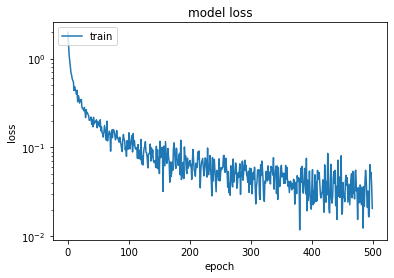

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
plt.semilogy(history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* x-axis walks through each pixel, y-axis shows the result

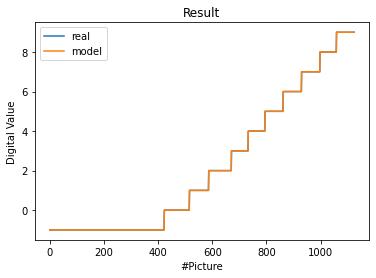

In [6]:
Input_dir='ziffer_sortiert_resize'
subdir = ["NaN", "0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
res = []

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    if aktsubdir == "NaN":
        zw1 = -1
    else:
        zw1 = int(aktsubdir)
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = -1
        zw2 = classes
        zw3 = zw2 - zw1
        res.append(np.array([zw1, zw2, zw3]))

res = np.asarray(res)


plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Digital Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [7]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp1r21ce_u\assets


219388

In [8]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for _ in range(500):
      data = np.random.rand(1, 32, 20, 3) * 255
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()

open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp84ak18wg\assets


INFO:tensorflow:Assets written to: C:\Users\Muell\AppData\Local\Temp\tmp84ak18wg\assets


63824

### Check each image for expected and deviation
* setting the switch "only_deviation = true" will only print the images for which the classification and the CNN-result deviates

The output contains the following information:

| Filename      | Expected Category           | Predicted Category        |
|------------- |:-----------------------------:|--------------|
| ziffer_sortiert_resize_NaN/5\Ziffer_4_0034.jpg | 4  | -1 |


In [9]:
Input_dir='ziffer_sortiert_resize'
only_deviation = True

subdir = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "NaN"]

for aktsubdir in subdir:
    files = glob.glob(Input_dir + '/' + aktsubdir + '\*.jpg')
    expected_class = aktsubdir
    for aktfile in files:
        test_image = Image.open(aktfile)
        test_image = np.array(test_image, dtype="float32")
        img = np.reshape(test_image,[1,32,20,3])
        classes = np.argmax(model.predict(img), axis=-1)
        classes = classes[0]
        if classes == 10: 
            classes = "NaN"
        if only_deviation == True:
            if str(classes) != str(expected_class):
                print(aktfile + " " + aktsubdir +  " " + str(classes))
        else:
            print(aktfile + " " + aktsubdir +  " " + str(classes))


Checking the images shows, that this are border line images, which can be interpreted as a good digit or a faulty one.